In [36]:
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sn

import tarfile
import urllib.request


In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

df = load_housing_data()

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The goal is to find median housing price in any district. Each row is data from 1 district.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df.shape

(20640, 10)

In [7]:
for column in df.columns:
    has_nan = df[column].isna().any()
    if has_nan:
        print(f"'{column}' column has NaN values.")

'total_bedrooms' column has NaN values.


In [8]:
df["ocean_proximity"].value_counts() # It's categorical and I can see the categories like this.

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


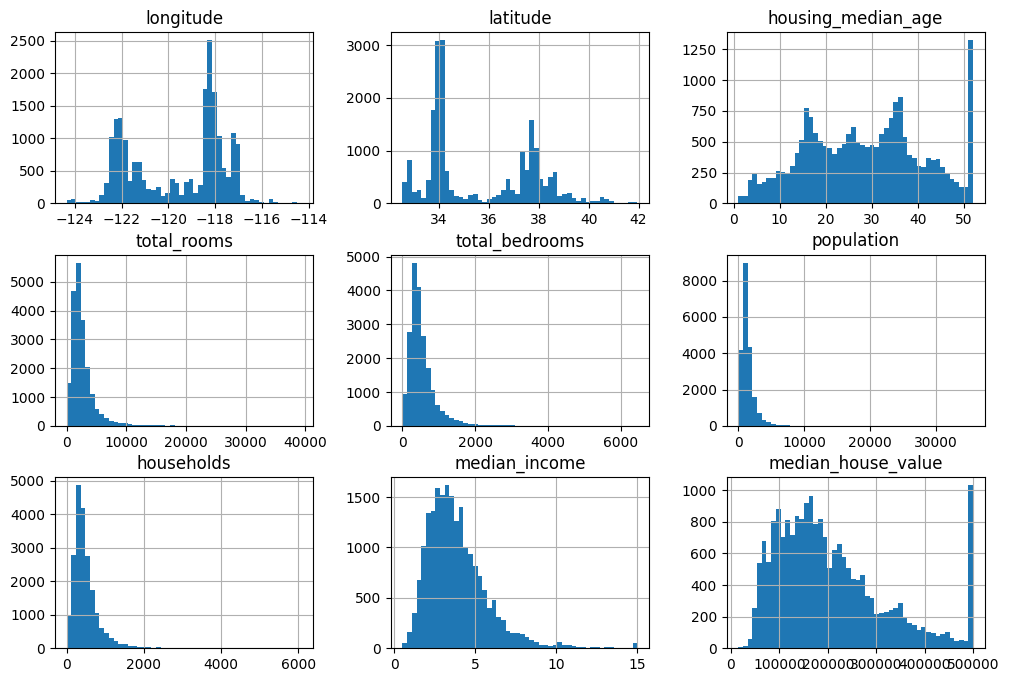

In [10]:
df.hist(bins=50, figsize=(12,8))
plt.show()

Things to realize about the data:

[x]First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in machine learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

[x]The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your machine learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

        1. Collect proper labels for the districts whose labels were capped.

        2. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

[x]These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.

[x]Finally, many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some machine learning algorithms to detect patterns. Later, you’ll try transforming these attributes to have more symmetrical and bell-shaped distributions.
        1. Some attributes have a skewed-right distribution, so you may want to transform them (e.g., by computing their logarithm or square root).

In [11]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
# Made an income category column.

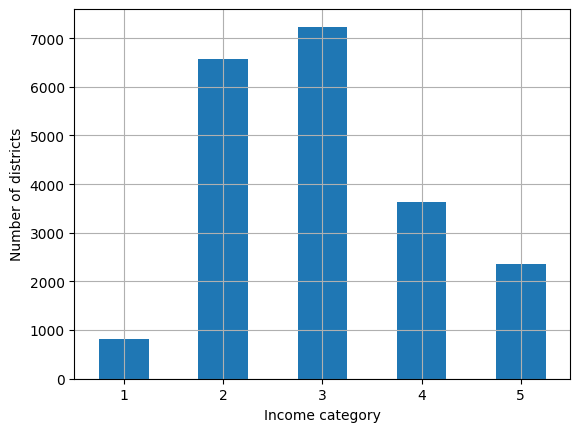

In [12]:
df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [13]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df["income_cat"], random_state=42)
# Stratified random sampling with income categories, because median income is an important attribute to predict median housing prices. (in context)

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
# Dropping the income category column because we don't need it anymore.

From now on, I only play around with the training set to avoid data snooping.

In [15]:
playtrain = strat_train_set.copy()
# Copying the training set to play with it.

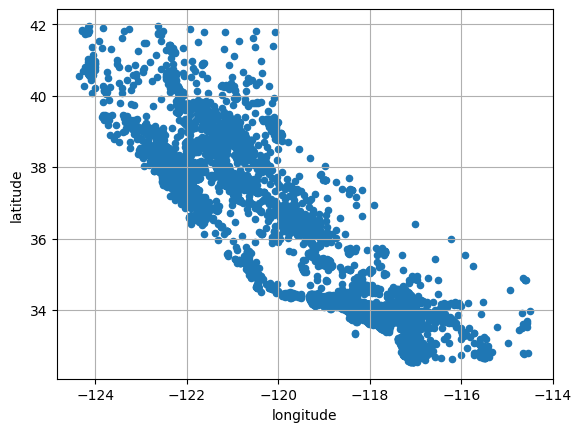

In [16]:
playtrain.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

Literally a map of California as Longitude and Latitude values are based on their positions in Cali. (It's a California dataset)

In [17]:
# I'm going to do alpha=0.2 to see the density of the points.

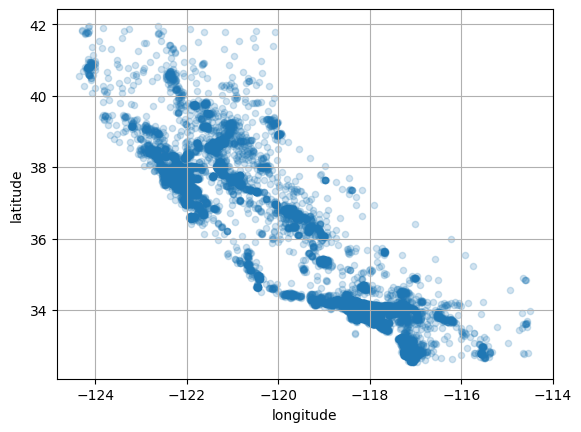

In [18]:
playtrain.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

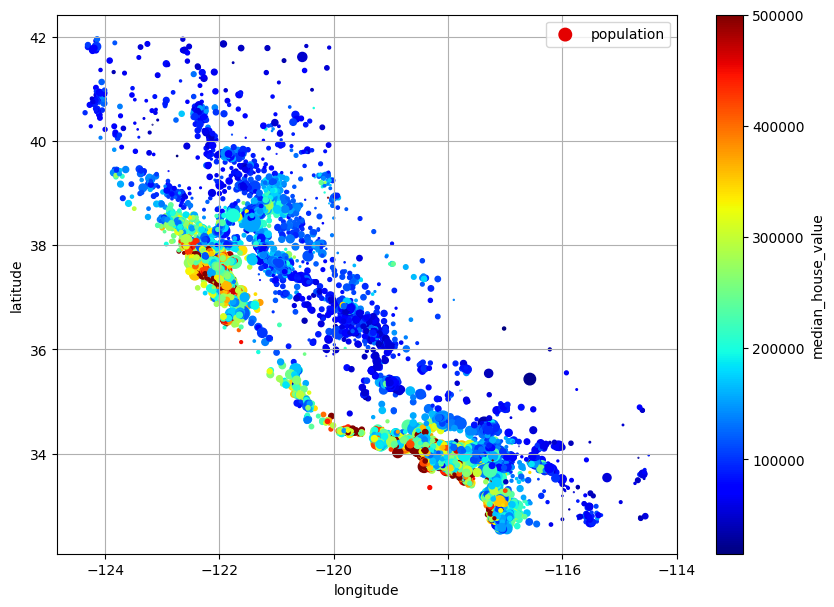

'\nMade a plot with a colorbar. \n\ns=housing["population"] / 100: Sets the size of the markers based on the population data from the housing DataFrame. The marker sizes are scaled down by a factor of 100.\n                            \nc="median_house_value":        Sets the color of the markers based on the median_house_value data from the housing DataFrame.\n\ncmap="jet":                    Specifies the colormap to be used for coloring the markers. The "jet" colormap ranges from blue to red.\n\n'

In [19]:
playtrain.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=playtrain["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

'''
Made a plot with a colorbar. 

s=housing["population"] / 100: Sets the size of the markers based on the population data from the housing DataFrame. The marker sizes are scaled down by a factor of 100.
                            
c="median_house_value":        Sets the color of the markers based on the median_house_value data from the housing DataFrame.

cmap="jet":                    Specifies the colormap to be used for coloring the markers. The "jet" colormap ranges from blue to red.

'''

<h1> Look for correlations

C:\Users\Aykut\AppData\Local\Temp\ipykernel_9856\62057546.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = playtrain.corr()


<Axes: >

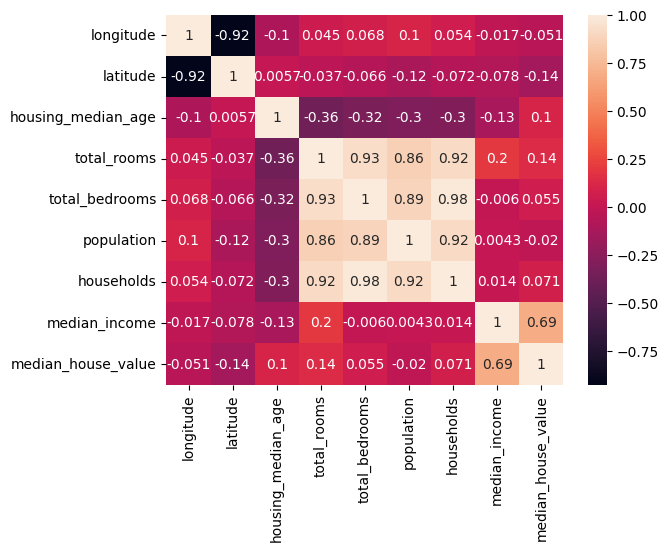

In [20]:
corr_matrix = playtrain.corr()
# corr_matrix
sn.heatmap(corr_matrix, annot=True)

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>,
        <Axes: xlabel='latitude', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>,
        <Axes: xlabel='latitude', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>,
        <Axes: xlabel='latitude', ylabel='total_rooms'>],
       [<Axes

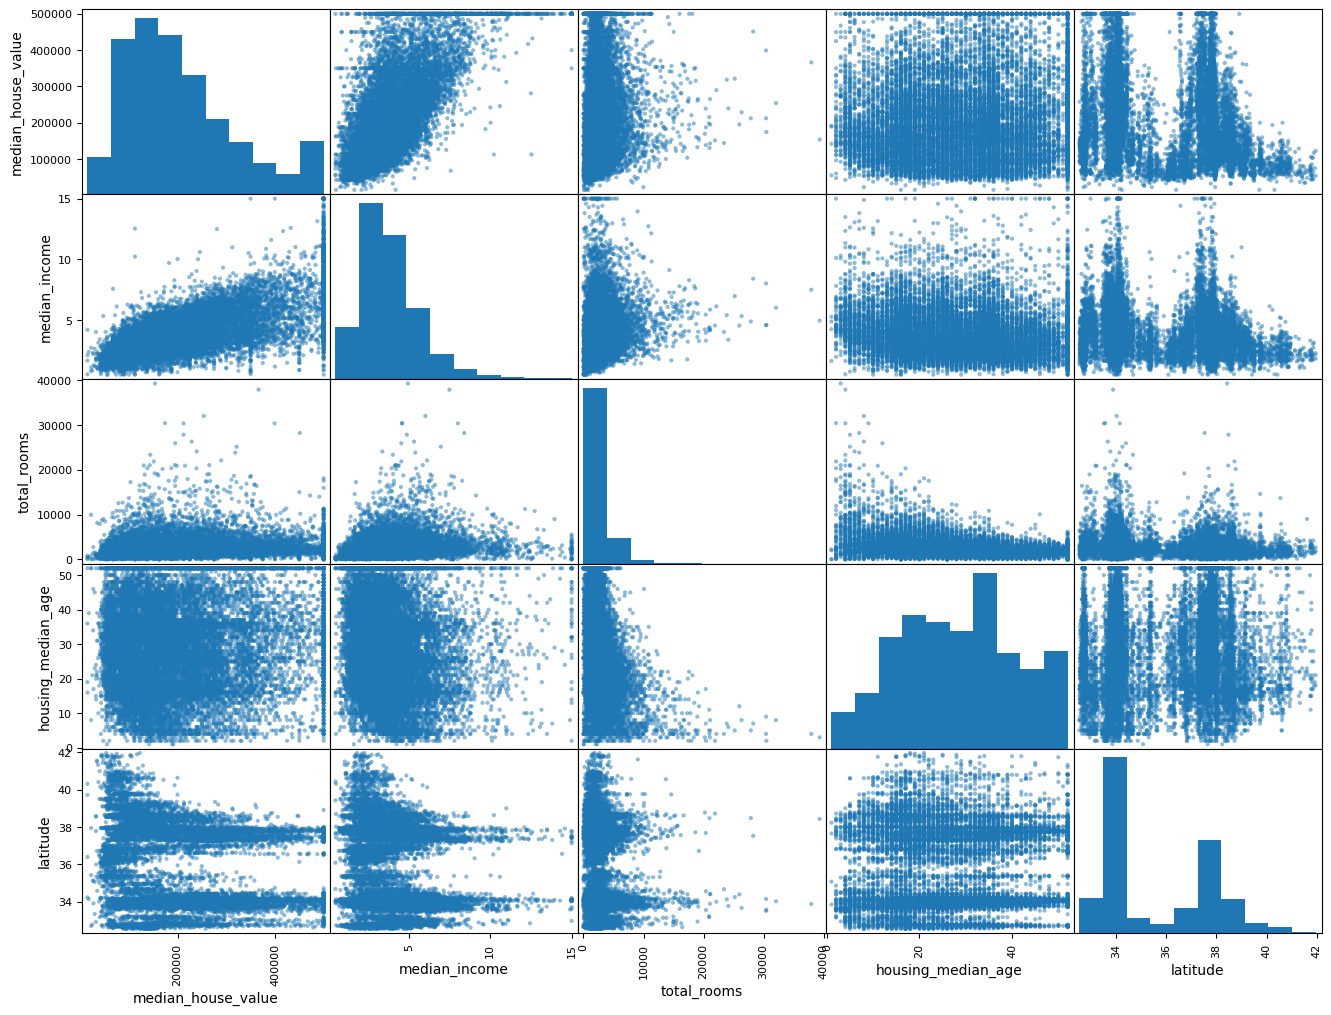

In [21]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "latitude"]

scatter_matrix(playtrain[attributes], figsize=(16, 12))

It seems like median income is the only one with positive correlation here. Let's check it out.

<Axes: xlabel='median_income', ylabel='median_house_value'>

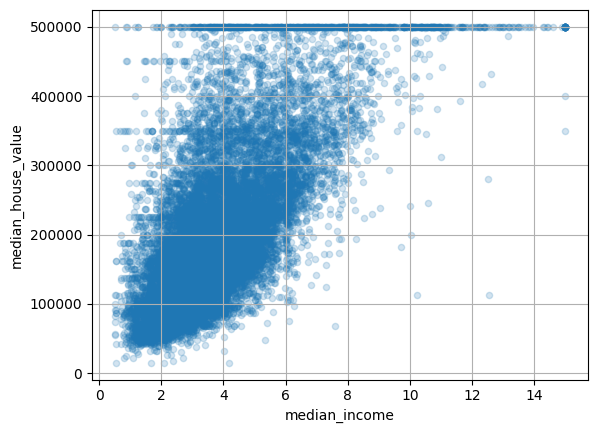

In [22]:
playtrain.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True)

We see a horizontal line at 500K, because the data was capped at that point but we also see feint horizontal lines between 400-500K, 300-400K, 280K... We should remove these from the data so we don't overfit.

In [23]:
playtrain["rooms_per_house"] = playtrain["total_rooms"] / playtrain["households"]
playtrain["bedrooms_ratio"] = playtrain["total_bedrooms"] / playtrain["total_rooms"]
playtrain["people_per_house"] = playtrain["population"] / playtrain["households"]

# Because the old attributes don't really mean much, I'm going to make new ones that make more sense.

C:\Users\Aykut\AppData\Local\Temp\ipykernel_9856\2988177416.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = playtrain.corr()


<Axes: >

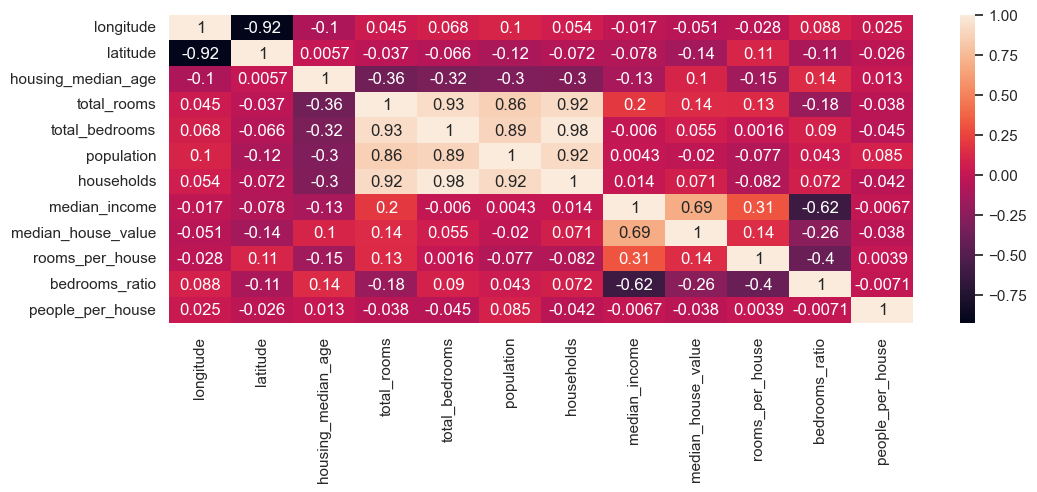

In [24]:
corr_matrix = playtrain.corr()
sn.set (rc = {'figure.figsize':(12, 4)})
sn.heatmap(corr_matrix, annot=True)

<h1> Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your machine learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:



1. This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).

2. You will gradually build a library of transformation functions that you can reuse in future projects.

3. You can use these functions in your live system to transform the new data before feeding it to your algorithms.

4. This will make it possible for you to easily try various transformations and see which combination of transformations works best.



In [25]:
cleaning_train= strat_train_set.copy()

# Reverting to a clean version of the training set.

In [26]:
'''

###################################################
I can use any one of these, but I'll use Scikit-Learn's SimpleImputer.

The benefit is that it will store the median value of each feature: 
This will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.
###################################################

cleaning_train.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

cleaning_train.drop("total_bedrooms", axis=1)  # option 2

cleaning_train = housing["total_bedrooms"].median()  # option 3

cleaning_train["total_bedrooms"].fillna(median, inplace=True)

'''

'\n\n###################################################\nI can use any one of these, but I\'ll use Scikit-Learn\'s SimpleImputer.\n\nThe benefit is that it will store the median value of each feature: \nThis will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.\n###################################################\n\ncleaning_train.dropna(subset=["total_bedrooms"], inplace=True)  # option 1\n\ncleaning_train.drop("total_bedrooms", axis=1)  # option 2\n\ncleaning_train = housing["total_bedrooms"].median()  # option 3\n\ncleaning_train["total_bedrooms"].fillna(median, inplace=True)\n\n'

In [27]:
imputer = SimpleImputer(strategy="median")

In [28]:
###################################################
# Because imputer can only work with numerical data, I'm going to drop the ocean_proximity column.
###################################################

cleaning_train_num = cleaning_train.select_dtypes(include=[np.number])
# Now I fit it to the training data so I can use it to impute missing values.
imputer.fit(cleaning_train_num)

SimpleImputer(strategy='median')

In [29]:
X = imputer.transform(cleaning_train_num)
# Now I have a NumPy array with the transformed features. I must make it a DataFrame again.

In [30]:
df_tr = pd.DataFrame(X, columns=cleaning_train_num.columns,
                          index=cleaning_train_num.index)

In [39]:
df_cat = cleaning_train[["ocean_proximity"]] # Made a dataframe with only the categorical columns.
df_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
dtype: int64

In [44]:
# If I use Scikit-Learn's OrdinalEncoder to convert the categorical values to numbers, it will think that nearby values are more similar than distant values.
# I will use Scikit-Learn's OneHotEncoder instead.

# ordinal_encoder = OrdinalEncoder()

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot

# By default, the output of a OneHotEncoder is a SciPy sparse matrix, instead of a NumPy array
# This is very useful when you have categorical attributes with thousands of categories.⁠
# A sparse matrix is a very efficient representation for matrices that contain mostly zeros. Indeed, internally it only stores the nonzero values and their positions.
# It will save plenty of memory and speed up computations
# You can use a sparse matrix mostly like a normal 2D array,⁠12 but if you want to convert it to a (dense) NumPy array, just call the toarray() method:

# OneHotEncoder is smarter that get_dummies because it remembers the columns it was fit to, and it can handle future data that has different categories.
# OneHotEncoder also raises an error if you feed it an unknown category.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>